In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from scipy import sparse

In [2]:
# Common Varibles
random_state=42
cv=5
scoring='roc_auc'
verbose=2

I'll be performing classification models on raw data and on OHE.

In [3]:
train_data=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
test_data=test.drop(columns=['id'],axis=1)

In [4]:
y_true=train_data['ACTION']
train_data=train_data.drop(['ACTION'],axis=1)
train_data.shape,y_true.shape

((32769, 9), (32769,))

In [5]:
#splitting the dataset
from sklearn.model_selection import train_test_split
# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(train_data,y_true, test_size=0.2,random_state=100)
x_train.shape,x_test.shape

((26215, 9), (6554, 9))

KNN classifier

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay

In [7]:
knn = KNeighborsClassifier(n_jobs=-1)
from sklearn.model_selection import RandomizedSearchCV
k_range=np.arange(1,100,5)
param_grid=dict(n_neighbors=k_range)
grid=RandomizedSearchCV(knn,param_grid,cv=cv,random_state=random_state,scoring=scoring,verbose=verbose)
grid_serch=grid.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......................................n_neighbors=1; total time=   3.4s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END .....................................n_neighbors=86; total time=   0.2s
[CV] END .....................................n_neighbors=86; total time=   0.2s
[CV] END .....................................n_neighbors=86; total time=   0.1s
[CV] END .....................................n_neighbors=86; total time=   0.1s
[CV] END .....................................n_neighbors=86; total time=   0.1s
[CV] END .....................................n_neighbors=76; total time=   0.1s
[CV] END .....................................n_

In [8]:
grid_serch.best_params_

{'n_neighbors': 26}

In [9]:
y_pred=grid.predict(x_test)
test_acc_knn=accuracy_score(y_test,y_pred)*100
test_acc_knn
# knn=KNeighborsClassifier(n_neighbors=8)
# knn.fit(x_train, y_train)
# y_pred=knn.predict(x_test)
# test_acc=accuracy_score(y_test,y_pred)*100
# test_acc

94.3240768996033

In [10]:
from sklearn.metrics import roc_auc_score
auc_knn = roc_auc_score(y_test,y_pred)
auc_knn

0.5013404825737265

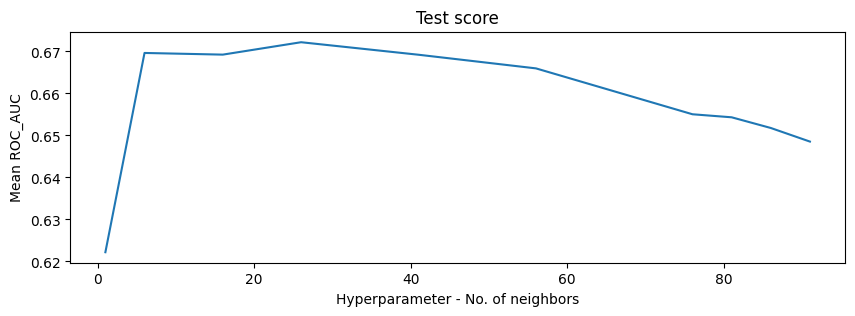

In [89]:
results=pd.DataFrame.from_dict(grid_serch.cv_results_)
results=results.sort_values('param_n_neighbors')
plt.figure(figsize=(10,3))
plt.plot(results['param_n_neighbors'],results['mean_test_score']);
plt.grid();
plt.xlabel('Hyperparameter - No. of neighbors');
plt.ylabel('Mean ROC_AUC');
plt.title('Test score'); 
plt.grid();

In [12]:
best_c=grid_serch.best_params_['n_neighbors']
best_c

26

In [13]:
model=KNeighborsClassifier(n_neighbors=best_c,n_jobs=-1)
model.fit(train_data,y_true)

KNeighborsClassifier(n_jobs=-1, n_neighbors=26)

In [14]:
prediction=model.predict_proba(test_data)[:,1]

In [15]:
submit = pd.DataFrame()
submit["Id"] = test["id"]
submit["ACTION"] = prediction
submit.to_csv("knn.csv", index = False)

In [16]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid.classes_)
# y_test.shape,y_pred.shape

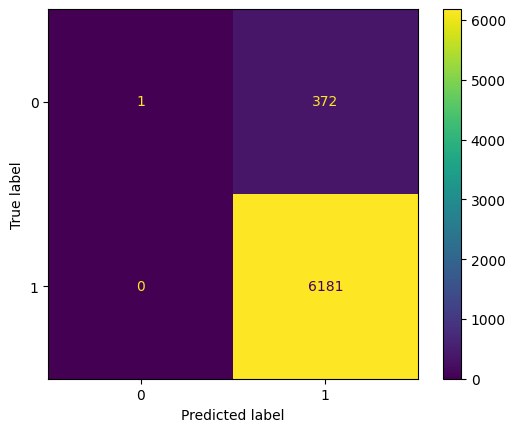

In [17]:
disp.plot()
plt.show()

KNN OHE

In [18]:
from scipy import sparse
train_ohe=sparse.load_npz('train_ohe.npz')
test_ohe=sparse.load_npz('test_ohe.npz')
train_ohe.shape,test_ohe.shape

((32769, 4500), (912363, 4500))

In [19]:
from sklearn.model_selection import GridSearchCV
parameters={'n_neighbors':np.arange(1,100,5)}
clf=RandomizedSearchCV(KNeighborsClassifier(),parameters,cv=cv,verbose=verbose,scoring=scoring,n_jobs=4)
# grid=RandomizedSearchCV(knn,param_grid,cv=cv,random_state=random_state,scoring=scoring,verbose=verbose)
best_model=clf.fit(train_ohe,y_true)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [20]:
result=pd.DataFrame.from_dict(best_model.cv_results_)
result=result.sort_values('param_n_neighbors')
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.018947,0.004547,26.551646,1.675076,1,{'n_neighbors': 1},0.622648,0.627625,0.609351,0.623683,0.638444,0.624350,0.009356,10
9,0.024537,0.009196,21.894138,7.820504,6,{'n_neighbors': 6},0.760056,0.794993,0.767923,0.750457,0.784015,0.771489,0.016094,9
6,0.014664,0.005637,34.474168,11.132145,11,{'n_neighbors': 11},0.790634,0.816172,0.795604,0.779872,0.808527,0.798162,0.012880,5
5,0.025936,0.018311,33.294116,5.440506,16,{'n_neighbors': 16},0.801253,0.819555,0.808495,0.782627,0.820162,0.806418,0.013846,1
1,0.021442,0.010549,19.467857,3.051742,31,{'n_neighbors': 31},0.807146,0.822594,0.804889,0.772999,0.816963,0.804918,0.017212,2
3,0.019550,0.007612,47.514027,16.151696,41,{'n_neighbors': 41},0.808601,0.817393,0.798101,0.770242,0.813244,0.801516,0.016909,3
8,0.025333,0.007263,42.544766,11.778944,46,{'n_neighbors': 46},0.804339,0.818778,0.797889,0.765292,0.807178,0.798695,0.018020,4
0,0.006781,0.000400,50.034443,22.797409,76,{'n_neighbors': 76},0.796652,0.814884,0.785648,0.765380,0.799800,0.792473,0.016456,6
4,0.041205,0.025226,36.310186,11.390940,91,{'n_neighbors': 91},0.790848,0.807480,0.783213,0.755993,0.801219,0.787750,0.017941,7
2,0.015859,0.007769,36.851383,7.097062,96,{'n_neighbors': 96},0.789727,0.808985,0.782888,0.757207,0.798482,0.787458,0.017470,8


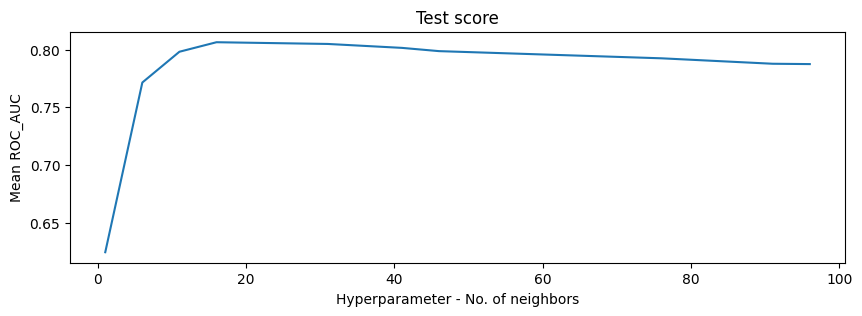

In [21]:
plt.figure(figsize=(10,3))
plt.plot(result['param_n_neighbors'],result['mean_test_score']);
plt.grid();
plt.xlabel('Hyperparameter - No. of neighbors');
plt.ylabel('Mean ROC_AUC');
plt.title('Test score'); 
plt.grid();

In [22]:
best_c=best_model.best_params_['n_neighbors']
best_c

16

In [23]:
model=KNeighborsClassifier(n_neighbors=best_c,n_jobs=-1)
model.fit(train_ohe,y_true)

KNeighborsClassifier(n_jobs=-1, n_neighbors=16)

In [28]:
# prediction=model.predict_proba(test_ohe)[:,1]

In [29]:
y_pred=model.predict(train_ohe)
test_acc_knn_ohe=accuracy_score(y_true,y_pred)*100
test_acc_knn_ohe

94.73587842167902

In [30]:
# submit = pd.read_csv('knn.csv')
# # submit["Id"] = test["id"]
# submit["ACTION_KNN_OHE"] = prediction
# submit.to_csv("knn.csv", index = False)

In [31]:
from sklearn.metrics import roc_auc_score
auc_knn_ohe = roc_auc_score(y_true, y_pred)
auc_knn_ohe

0.5643828572767273

In [32]:
from prettytable import PrettyTable
x = PrettyTable(['Model', 'Feature', 'Accuracy', 'ROC_AUC'])
x.add_row(['KNN', '-', math.trunc(test_acc_knn), auc_knn])
x.add_row(['KNN','ohe', test_acc_knn_ohe, auc_knn_ohe])
print(x)

+-------+---------+-------------------+--------------------+
| Model | Feature |      Accuracy     |      ROC_AUC       |
+-------+---------+-------------------+--------------------+
|  KNN  |    -    |         94        | 0.5013404825737265 |
|  KNN  |   ohe   | 94.73587842167902 | 0.5643828572767273 |
+-------+---------+-------------------+--------------------+


Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

In [37]:
C_val = uniform(loc=0, scale=4)
lr=LogisticRegression(verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=500,n_jobs=-1)
parameters={'C':C_val}
clf=RandomizedSearchCV(lr,parameters,verbose=verbose,cv=cv,random_state=random_state,scoring=scoring,n_iter=100,n_jobs=-1)
best_model=clf.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [46]:
best_c=best_model.best_params_['C']
best_c

0.08233797718320979

In [68]:
result=pd.DataFrame.from_dict(best_model.cv_results_)
result.sort_values('param_C')
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.879858,0.067487,0.007382,0.001357,1.49816,{'C': 1.49816047538945},0.882175,0.884794,0.867969,0.860300,0.879737,0.874995,0.009331,32
1,2.411559,0.121139,0.006586,0.000585,3.802857,{'C': 3.8028572256396647},0.877215,0.881082,0.863760,0.853882,0.876353,0.870458,0.010128,90
2,2.263799,0.074374,0.006183,0.000977,2.927976,{'C': 2.9279757672456204},0.878901,0.882397,0.865189,0.855891,0.877620,0.872000,0.009932,69
3,2.025757,0.121552,0.006981,0.000630,2.394634,{'C': 2.3946339367881464},0.880098,0.883256,0.866305,0.857327,0.878459,0.873089,0.009755,54
4,1.330377,0.093749,0.006288,0.000599,0.624075,{'C': 0.6240745617697461},0.883070,0.885069,0.868076,0.863123,0.879878,0.875843,0.008669,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.742405,0.103048,0.006193,0.000505,1.975182,{'C': 1.975182385457563},0.881030,0.884030,0.867078,0.858709,0.879082,0.873986,0.009566,41
96,1.755491,0.078291,0.006184,0.000398,2.090931,{'C': 2.0909313175279762},0.880764,0.883845,0.866901,0.858277,0.878889,0.873735,0.009631,45
97,1.631379,0.113568,0.006489,0.000899,1.710164,{'C': 1.7101640734341985},0.881712,0.884413,0.867659,0.859601,0.879482,0.874574,0.009422,35
98,0.565771,0.055644,0.005289,0.001825,0.101677,{'C': 0.10167650697638075},0.868155,0.870643,0.849562,0.850073,0.868926,0.861472,0.009551,98


In [51]:
model=LogisticRegression(C=best_c,verbose=verbose,random_state=random_state,class_weight='balanced',n_jobs=-1)
model.fit(train_data,y_true)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished


LogisticRegression(C=0.08233797718320979, class_weight='balanced', n_jobs=-1,
                   random_state=42, verbose=2)

In [55]:
y_pred=model.predict(x_test)
test_acc_lr=accuracy_score(y_test,y_pred)*100
auc_lr = roc_auc_score(y_test,y_pred)
test_acc_lr,auc_lr

(50.15257857796765, 0.5304092841810044)

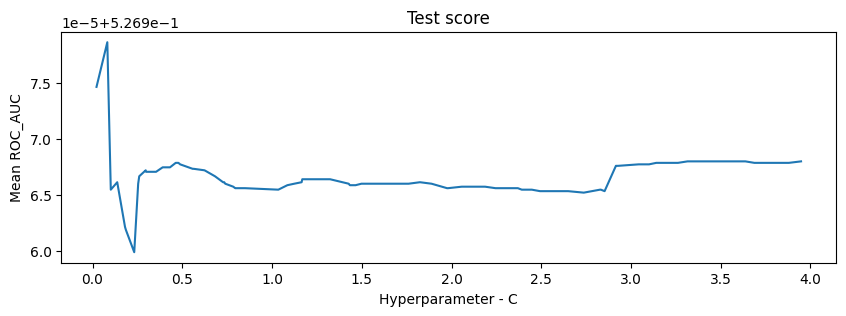

In [57]:
results=pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
plt.figure(figsize=(10,3))
plt.plot(results['param_C'],results['mean_test_score']);
plt.grid();
plt.xlabel('Hyperparameter - C');
plt.ylabel('Mean ROC_AUC');
plt.title('Test score'); 
plt.grid();

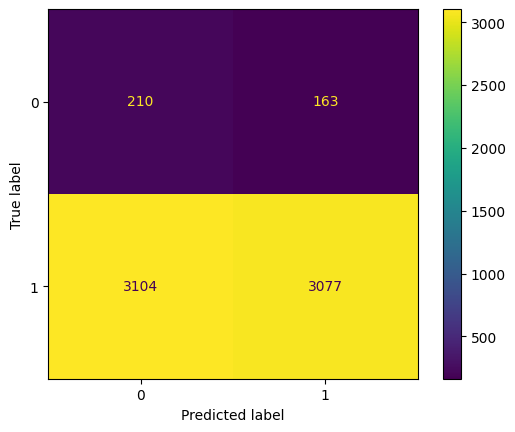

In [59]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_model.classes_)
disp.plot()
plt.show()

Logistic Regression OHE

In [64]:
train_ohe.shape,test_ohe.shape,y_true.shape

((32769, 4500), (912363, 4500), (32769,))

In [65]:
C_val = uniform(loc=0, scale=4)
lr=LogisticRegression(verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=500,n_jobs=-1)
parameters={'C':C_val}
clf=RandomizedSearchCV(lr,parameters,verbose=verbose,cv=cv,random_state=random_state,scoring=scoring,n_iter=100,n_jobs=-1)
best_model=clf.fit(train_ohe,y_true)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [67]:
best_c=best_model.best_params_['C']
best_c

0.7948627261366896

In [71]:
result=pd.DataFrame.from_dict(best_model.cv_results_)
result=result.sort_values('param_C')
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
72,0.385792,0.016339,0.006089,0.000484,0.022088,{'C': 0.022088468494409597},0.827415,0.833777,0.808035,0.814502,0.841708,0.825087,0.012329,100
10,0.571923,0.037734,0.007182,0.000398,0.082338,{'C': 0.08233797718320979},0.864374,0.867161,0.845380,0.846580,0.866256,0.857950,0.009822,99
98,0.565771,0.055644,0.005289,0.001825,0.101677,{'C': 0.10167650697638075},0.868155,0.870643,0.849562,0.850073,0.868926,0.861472,0.009551,98
42,0.834569,0.083604,0.006782,0.000746,0.137554,{'C': 0.13755408446087358},0.872632,0.874930,0.855066,0.854638,0.872126,0.865878,0.009053,97
58,0.975827,0.143524,0.008087,0.003729,0.180909,{'C': 0.18090915564215226},0.875813,0.877965,0.859005,0.857691,0.874480,0.868991,0.008771,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2.411559,0.121139,0.006586,0.000585,3.802857,{'C': 3.8028572256396647},0.877215,0.881082,0.863760,0.853882,0.876353,0.870458,0.010128,90
34,2.302796,0.062598,0.006183,0.000399,3.862528,{'C': 3.8625281322982374},0.877135,0.880991,0.863656,0.853775,0.876278,0.870367,0.010138,91
50,2.259850,0.152672,0.007181,0.000748,3.878339,{'C': 3.8783385110582342},0.877105,0.880956,0.863630,0.853730,0.876245,0.870333,0.010142,92
11,2.132061,0.059868,0.006784,0.000399,3.879639,{'C': 3.8796394086479773},0.877091,0.880962,0.863608,0.853724,0.876251,0.870327,0.010146,93


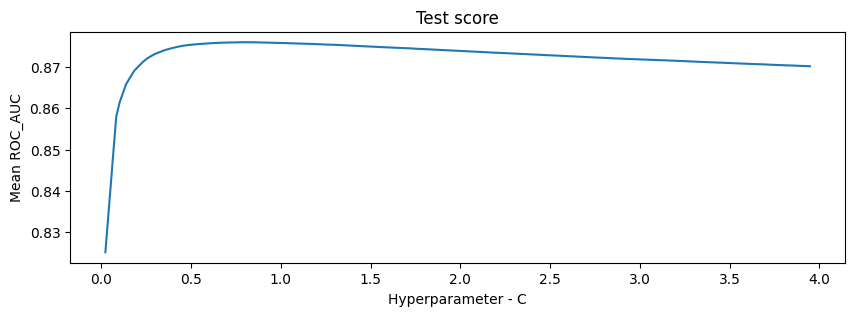

In [72]:
plt.figure(figsize=(10,3))
plt.plot(result['param_C'],result['mean_test_score']);
plt.grid();
plt.xlabel('Hyperparameter - C');
plt.ylabel('Mean ROC_AUC');
plt.title('Test score'); 
plt.grid();

In [73]:
model=LogisticRegression(C=best_c,verbose=verbose,random_state=random_state,class_weight='balanced',n_jobs=-1)
model.fit(train_ohe,y_true)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.2s finished


LogisticRegression(C=0.7948627261366896, class_weight='balanced', n_jobs=-1,
                   random_state=42, verbose=2)

In [77]:
y_pred=model.predict(train_ohe)
test_acc_lr_ohe=accuracy_score(y_true,y_pred)*100
auc_lr_ohe = roc_auc_score(y_true, y_pred)
test_acc_lr_ohe,auc_lr_ohe

(91.88562360767799, 0.9413502628159217)

In [79]:
from prettytable import PrettyTable
x = PrettyTable(['Model', 'Feature', 'Accuracy', 'ROC_AUC'])
x.add_row(['Logistic Regression', '-', (test_acc_knn), auc_lr])
x.add_row(['Logistic Regression','ohe', test_acc_lr_ohe, auc_lr_ohe])
print(x)

+---------------------+---------+-------------------+--------------------+
|        Model        | Feature |      Accuracy     |      ROC_AUC       |
+---------------------+---------+-------------------+--------------------+
| Logistic Regression |    -    |  94.3240768996033 | 0.5304092841810044 |
| Logistic Regression |   ohe   | 91.88562360767799 | 0.9413502628159217 |
+---------------------+---------+-------------------+--------------------+
